# Geophysical Tutorial Machine Learning Contest 2016

O processo de previsão das propriedades espaciais, principalmente da litologia (litofácies), é decisivo para o sucesso da produção de hidrocarbonetos em reservatórios de petróleo. Essa previsão pode ser guiada pela associação de dados físicos e de sísmica obtidos dos poços. 

Nesse nosso caso, os recursos serão dados de registro de poço de oito poços de gás. Esses poços já tiveram classes de litofácies atribuídas com base nas descrições de núcleos. Depois de treinar um classificador, vamos usá-lo para atribuir fácies a poços que não foram descritos.

Esse notebook aplicará a técnicas de Machine Learning denominada Support Vector Machine (SVM), para a classificação automática de litofácies de perfis de poço com base nos dados fornecidos no Geophysical Tutorial Machine Learning Contest 2016 (https://github.com/seg/2016-ml-contest).  

Para mais detalhes sobre SVM: https://en.wikipedia.org/wiki/Support-vector_machine.

# 1 - Importar as bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2 - Carregar o conjunto de dados

O conjunto de dados consiste em onze entradas: um rótulo de fácies em intervalos de profundidade de meio pé (numérico), seis medições de registros wireline (numérico), formação perfurada e nome dos poços (categóricos), profundidade (numérico) e um indicador da localização dos poços (numérico), com as seguintes legendas: 
 
- Facies: classes de litofácies atribuídas com base na análise prévia de testemunhos. 
- Formation: tipo de formação associada a cada medição.
- Well Name: o nome do poço no qual foram realizadas as medições.
- Depth: a profundidade na qual foram realizadas as medições.
- GR (Gamma-Ray): Perfil de raios gama.
- ILD_log10: Perfil de resistividade.
- DeltaPHI: Diferença de porosidade de densidade de nêutrons
- PHIND: Porosidade média de densidade de nêutrons.
- PE: Perfil de efeito fotoelétrico.
- NM_M: Indicador não marinho (1)/ marinho (2)
- RELPOS: Posição relativa

In [2]:
df = pd.read_csv('data.csv')
print(df.shape)
df

(3232, 11)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


Podemos ver na linha de contagem que temos um total de 3232 amostras para cada uma das 11 entradas do conjunto de dados.

Existem nove classes de fácies (numeradas de 1 a 9) identificadas no conjunto de dados. 

In [3]:
np.sort(df.Facies.unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Vamos verificar a distribuição de classes para os dados marinhos e não marinhos.

In [4]:
np.sort(df.loc[df['NM_M']==1].Facies.unique())

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [5]:
np.sort(df.loc[df['NM_M']==2].Facies.unique())

array([2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Vemos que a classe 9 não está presente nos dados não marinhos e a classe 1 não está presente nos dados marinhos.

O conjunto de dados possue ao todo 8 poços.

In [6]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

E os poços cruzam um total de 14 formações diferentes.

In [7]:
df['Formation'].unique()

array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM'],
      dtype=object)

O comando abaixo mostra a descrição estatística geral do conjunto de dados.

In [8]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


É importante verificar se não há dados ausentes no conjunto de dados. Na linha 'count' podemos observar que todos os recursos possuem 3232 medições, o que indica que não há dados ausentes. 

Podemos confirmar isso através do comando abaixo, que nos dará a quantidade de dados ausentes nas colunas do conjunto de dados. 

In [9]:
df.isnull().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

# 3 - Visualizar dos dados

Os gráficos cruzados são uma ótima ferramenta para visualizar como duas propriedades variam com o tipo de rocha.

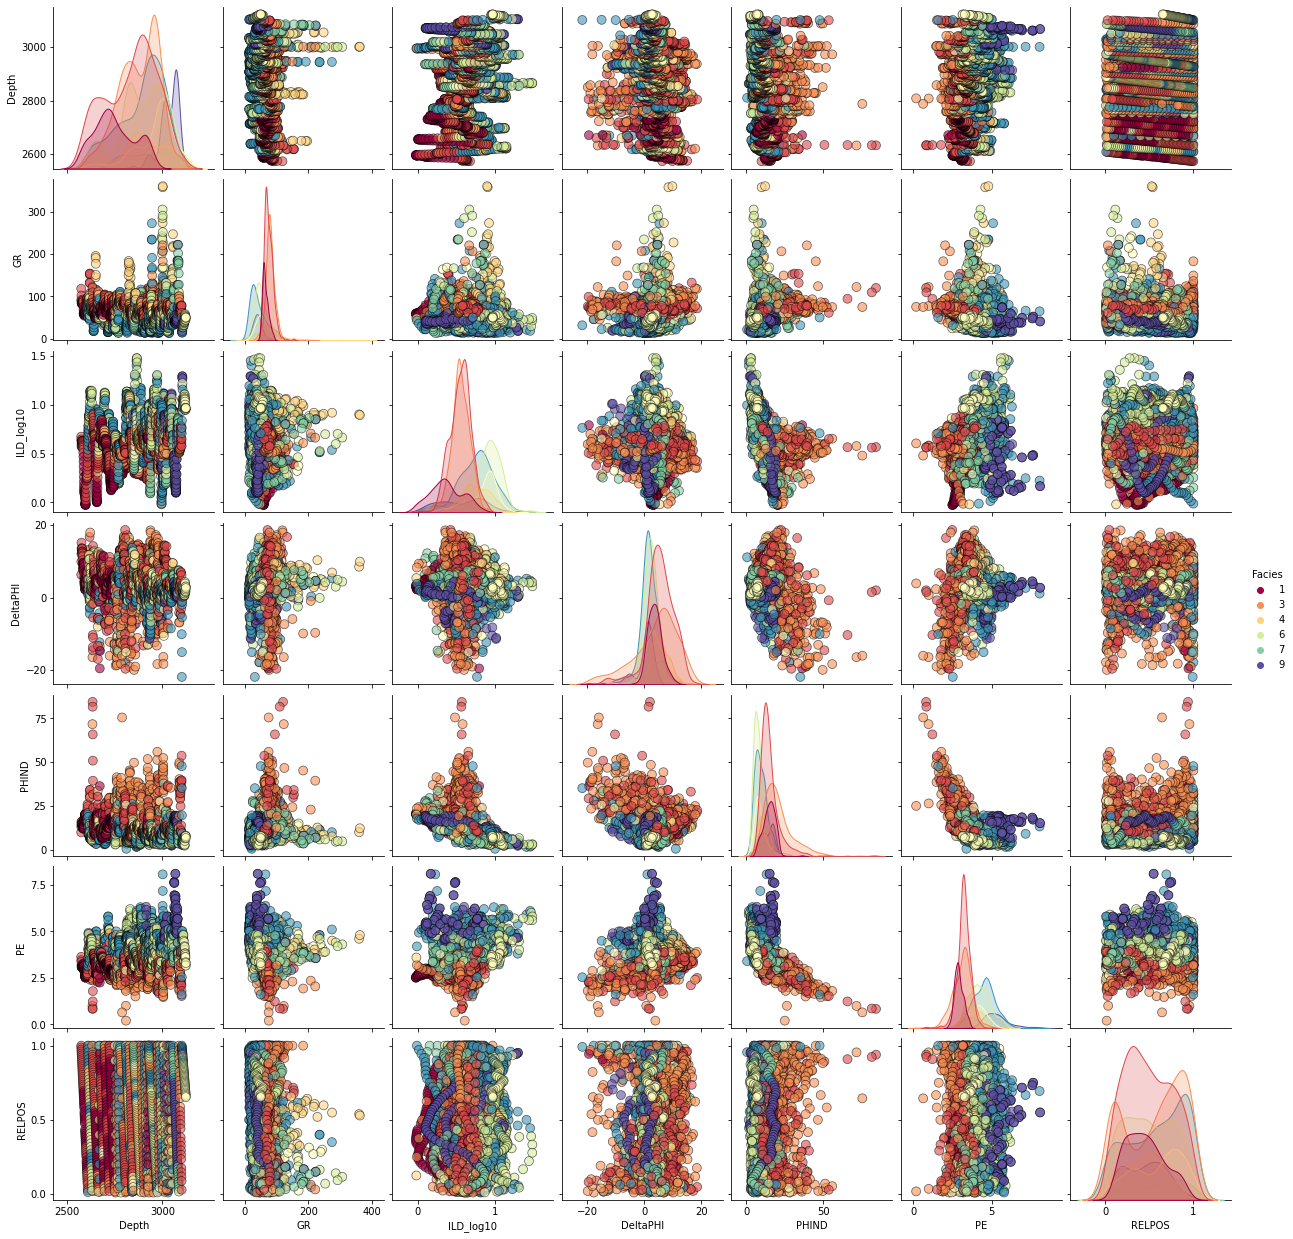

In [10]:
df_plot = df.drop('NM_M', axis=1)
g = sns.pairplot(df_plot, hue = 'Facies', diag_kind = 'kde',  kind='scatter', height=2.5,
            plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, palette='Spectral')

sns.set_context("paper", font_scale=2.0)
    
plt.show()

Vemos que as classes estão longe de serem linearmente separáveis e por isso a escolha do algoritmo SVM para o processo de classificação. De modo resumido, o que ele faz é transportar os recursos para um dimensão superior, chamada dimensão de recursos, onde espera-se que estes sejam linearmente separáveis.

Vamos checar a distribuição das frequencias de cada classe dentro do banco de dados.

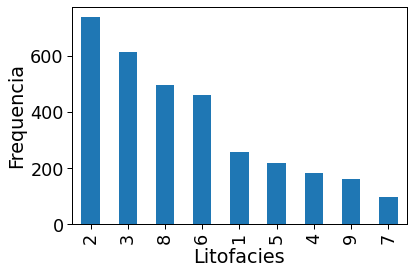

In [11]:
df.Facies.value_counts(sort=True).plot(kind='bar')
plt.ylabel('Frequencia')
plt.xlabel('Litofacies')
plt.show()

Pode-se notar que há um certo grau de desbalanço entre as litofácies, que pode ser visualizado em termos percentuais pelo comando abaixo.  

In [12]:
round((df['Facies'].value_counts(sort=True))*100/len(df['Facies']),2)

2    22.83
3    19.03
8    15.41
6    14.29
1     8.01
5     6.71
4     5.69
9     4.98
7     3.03
Name: Facies, dtype: float64

As classes 2,3,8 e 6 tendem a serem aprendidas com maior facilidade, pelas suas frequências e o relativo equilíbrio entre elas. Espera-se que o modelo tenha maiores dificuldades no aprendizado das classes 1,5,4,9 e 7, pelo motivo oposto.

O desbalanço entre as classes também pode induzir o modelo a um invés no momento das predições. 

# 4 - Contrução do modelo

In [30]:
from sklearn.svm import SVC # importa o modelo SVM
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

Vamos inicialmente separar os dados em treinamento e teste. Vamos escolher como poço de teste o 'SHANKLE', ao passo que o modelo será treinado nos demais poços. 

In [14]:
test_well = df[df['Well Name'] == 'SHANKLE']
df_train = df[df['Well Name'] != 'SHANKLE']

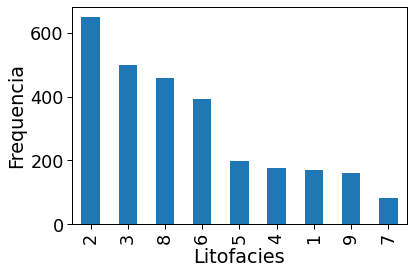

In [15]:
df_train.Facies.value_counts(sort=True).plot(kind='bar')
plt.ylabel('Frequencia')
plt.xlabel('Litofacies')
plt.show()

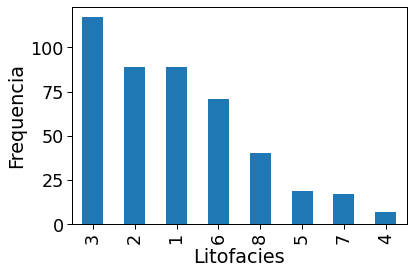

In [16]:
test_well.Facies.value_counts(sort=True).plot(kind='bar')
plt.ylabel('Frequencia')
plt.xlabel('Litofacies')
plt.show()

Para evitar problemas com o "vazamento de dados" (data leakage), vamos criar um pipeline para preparação dos dados dentro do processo de avaliação e validação do modelo nos dados de treinamento.

- Para mais detalhes ver: https://en.wikipedia.org/wiki/Leakage_(machine_learning)

O modelo SVM tem alguns parâmetros para serem ajustados, isso será feito por meio da função GridSearchCV por meio de uma validação cruzada com k-fold=5 e métrica f1-score.
 
- A função GridSearchCV não é o modo mais otimizado de se fazer ajuste de parâmetros. No entanto, como esse exemplo tem pequena dimensão, optamos por seu uso.  
 

Para mais detalhes:

- https://scikit-learn.org/stable/modules/svm.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/grid_search.html

O modelo será construido com base nos recursos: Depth, GR, ILD_log10, DeltaPHI, PHIND, PE, NM_M e RELPOS.

In [17]:
def df_Xy_Split(df):
    X = df.drop(['Facies', 'Formation', 'Well Name'], axis=1)
    y = df['Facies']
    
    return X,y

In [18]:
X_train,y_train = df_Xy_Split(df_train)

In [19]:
X_train

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...
3227,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


********************************************************************************
Pontuação média:		51.95%
Melhor pontuação:		60.37%
Parametros:	{'svc__C': 100.0, 'svc__gamma': 0.005}
********************************************************************************


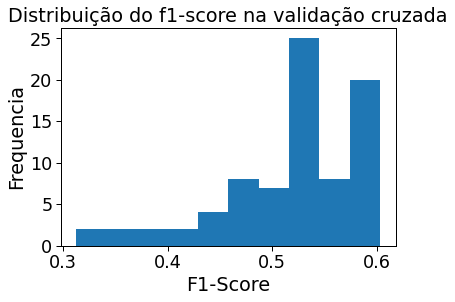

In [20]:
# definir o pipeline
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('svc', SVC()))
pipeline = Pipeline(steps=steps)

# definir os procedimentos de ajuste de parâmetros
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=0)

svm_parameters = {'svc__C':  np.linspace(30,100,20), 
                   'svc__gamma':  [0.0001, 0.0005, 0.001, 0.005]}

svm_grid = GridSearchCV(pipeline, svm_parameters, scoring='f1_macro', n_jobs =-1, cv=cv).fit(X_train,y_train)
svm_clf = svm_grid.best_estimator_.fit(X_train,y_train)

print('*' * 80)
print('Pontuação média:\t\t{:.2%}'.format(np.mean(svm_grid.cv_results_['mean_test_score'])))
print('Melhor pontuação:\t\t{:.2%}'.format(svm_grid.best_score_))
print('Parametros:\t{}'.format(svm_grid.best_params_))
print('*' * 80)

plt.hist(svm_grid.cv_results_['mean_test_score'])
plt.title('Distribuição do f1-score na validação cruzada')
plt.xlabel('F1-Score')
plt.ylabel('Frequencia')
plt.show()

- Pelo gráfico acima nota-se que a maioria das pontuações f1-score estão entre 42 e 60%, aproximadamente.
 
- Outro ponto a se destacar é que a pontuação média e máxima estão relativamente próximas também. 
 
- As pontuações mais baixas podem ser explicadas pelas complexas variações litológicas entre os poços que compõem o conjunto de dados de treinamento, o que pode impor muitas dificuldades ao algoritmo em algumas dobras da validação cruzada. 
 
- Nesse ponto, pode-se testar outros métodos para se criar as dobras da validação cruzada e analisar o comportamento do algoritmo para cada uma delas.  
 
- Para mais detalhes: https://scikit-learn.org/stable/modules/cross_validation.html.


# 5 - Predições do modelo

In [21]:
from matplotlib.pyplot import cm

Aplicaremos abaixo o mesmo Pipeline utilizado no treinamento nos dados de teste. 

In [22]:
# Separar recursos e alvos
X_test,y_test = df_Xy_Split(test_well)

In [23]:
# Previsões do modelo
svm_pred = svm_clf.predict(X_test)

# 6 - Avaliação do modelo

In [24]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

Para avaliação do modelo usaremos as métricas clássicas: acurácia, precisão, recall e f1-score.

- Para mais detalhes sobre métricas de classificação: https://bit.ly/genesisMetrics1

In [25]:
# Métricas do modelo
print(metrics.classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           1       1.00      0.07      0.13        89
           2       0.33      0.75      0.46        89
           3       0.72      0.52      0.60       117
           4       0.05      0.14      0.08         7
           5       0.25      0.21      0.23        19
           6       0.65      0.75      0.70        71
           7       1.00      0.71      0.83        17
           8       0.64      0.40      0.49        40

    accuracy                           0.49       449
   macro avg       0.58      0.44      0.44       449
weighted avg       0.66      0.49      0.47       449



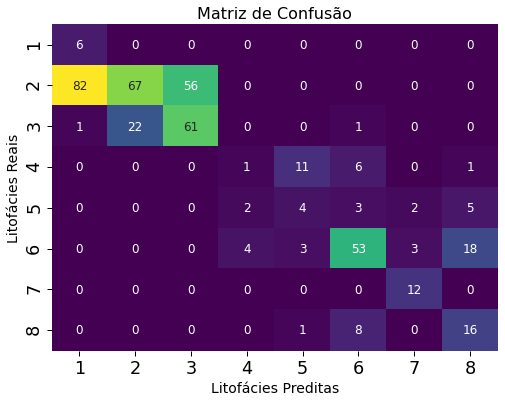

In [35]:
# Matriz de Confusão
target_names = np.unique(y_test).tolist()
f, ax = plt.subplots(figsize=(8, 6))
mat = metrics.confusion_matrix(y_test, svm_pred)
g = sns.heatmap(mat.T, annot=True, fmt="d",  cmap='viridis', cbar=False, linewidths=0.0, annot_kws={"size": 12}, 
                xticklabels=target_names ,  yticklabels=target_names)
ax.set_title('Matriz de Confusão', fontsize = 16)
ax.set_ylabel('Litofácies Reais', fontsize = 14) 
ax.set_xlabel('Litofácies Preditas', fontsize = 14)
plt.show()

- A acurácia total do modelo foi 49%, ao passo que as médias de precisão, recall e f1-score foram de 58, 44 e 44%, respectivamente. 
- Nota-se também que o modelo teve melhor desempenho na classificação das classes mais frequentes e pior nas menos frequentes, como esperado. 
- Esses resultados evidenciam a complexidade do problema de classificação de litofácies, devido às relações fortemente não lineares entre as medidas de perfis e as variações litológicas. 

Essa abordagem supera a descrita em Hall, B. (2016), o qual também usa SVM no mesmo problema.


Vamos construir um gráfico para ilustrar a distribuição da litofacies reais e preditas ao longo do poço, em relação aos recursos do modelo.

In [62]:
import matplotlib.colors as colors

In [63]:
# Criar um dicionário de cores para as litofácies
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = np.sort(df.Facies.unique())

facies_color_map = {}
facies_number_dic = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    facies_number_dic[label] = ind+1 

In [92]:
def data_plot(X,y, y_pred, facies_colors = facies_colors):

    df = X.sort_values(by='Depth')
    
    ztop=df.Depth.min(); zbot=df.Depth.max()
    ncols = len(df.columns)+1
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(18, 12))
    
    color=iter(cm.rainbow(np.linspace(0,1,ncols)))
    
    for i in np.arange(1,ncols-1):
        col_name = df.iloc[:,i].name
        c = next(color)
        ax[i-1].plot(df.iloc[:,i], df.Depth, c=c)
        ax[i-1].set_xlabel(col_name, fontsize = 14); 
 
        ax[i].set_yticklabels([]);
        
        ax[i-1].set_ylim(ztop,zbot)
        ax[i-1].invert_yaxis()
        ax[i-1].grid([])
        ax[i-1].locator_params(axis='x', nbins=3)
    
    ax[0].set_ylabel("Profundidade (ft)", fontsize = 20)
    
    ax[-1].grid([]); ax[-1].set_xlabel('Predição', fontsize = 14); 
    ax[-1].set_yticklabels([]); ax[-1].set_xticklabels([]);
    
    ax[-2].grid([]); ax[-2].set_xlabel('Real', fontsize = 14); 
    ax[-2].set_yticklabels([]); ax[-2].set_xticklabels([]);    
    
    # plotar as cores das petrofacies 
    cmap_faces = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    cluster1 = np.repeat(np.expand_dims(y.values,1), 100, 1)
    im1 = ax[-2].imshow(cluster1, interpolation='none', aspect='auto', cmap=cmap_faces,vmin=1,vmax=9)
    cluster2 = np.repeat(np.expand_dims(y_pred,1), 100, 1)
    im2 = ax[-1].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_faces,vmin=1,vmax=9)


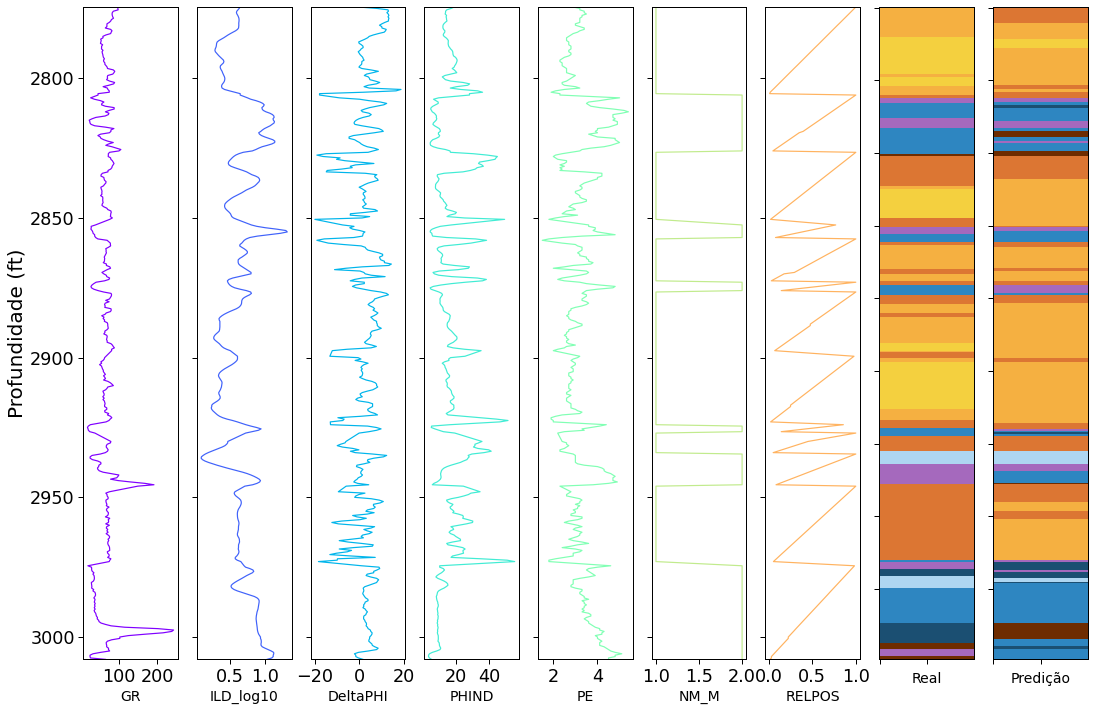

In [94]:
data_plot(X_test,y_test, svm_pred)